Tensorflow 1.4.0 is required.
This is based on [NMT Tutorial](https://github.com/tensorflow/nmt).

## notes
* Training w/o USERNAME token
  * replacing @username with USERNAME token caused high frequency of appearence of USERNAME. The result was poor.
  * So simply replacing it with "".
  * [commit](https://github.com/higepon/tensorflow_seq2seq_chatbot/commit/a2d53ee1b3196bffc97c226230e41e25a1b46904)
* Make Attention work
  * Now beam/greedy can't work together.
* Testing Attention if it coverges with learning rate
  * Adam 0.05 and age decay 0.99 didn't work, perplexity stays around 50000-100000
  * Adam 0.5, didn't work
  * SGD with learning rate = 0.5 paramter no decay, worked very well.
    * perplexity goes down to around 80
    * おはよう -> おはようございます
    * [commit](https://github.com/higepon/tensorflow_seq2seq_chatbot/commit/c9e230a4fbd485e89f838af9e33b1d9c9f7bc0d0)
    * 'num_layers': 3, 'vocab_size': 50000, 'embedding_size': 1024
  
  
  



In [0]:
from __future__ import print_function



# @formatter:off
import copy as copy
import datetime
import os
import re
import shutil
from pathlib import Path
from enum import Enum

import numpy as np
import tensorflow as tf
from tensorflow.python.layers import core as layers_core
from tensorflow.python.platform import gfile

#@formatter:on


def colab():
    return '/tools/node/bin/forever' == os.environ['_']


if colab():
    import matplotlib.pyplot as plt

# Note for myself.
# You've summarized Seq2Seq
# at http://d.hatena.ne.jp/higepon/20171210/1512887715.

# If you see following error, it means your max(len(tweets of training set)) <  decoder_length.
# This should be a bug somewhere in build_decoder, but couldn't find one yet.
# You can workaround by setting hparams.decoder_length=max len of tweet in training set.
# InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [48,50] and labels shape [54]
#	 [[Node: root/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, 

print(tf.__version__)

def data_dir():
    target_dir = "{}/chatbot_data".format(str(Path.home()))
    if not colab() and not os.path.exists(target_dir):
        raise Exception("{} not found, you may create".format(target_dir))
    return target_dir


def info(message, hparams):
    if hparams.debug_verbose:
        print(message)


def p(path):
    if colab():
        return path
    else:
        return "{}/{}".format(data_dir(), path)


def has_gpu0():
    return tf.test.gpu_device_name() == "/device:GPU:0"


class ModelDirectory(Enum):
    tweet_large = 'model/tweet_large'
    tweet_large_swapped = 'model/tweet_large_swapped'
    tweet_small = 'model/tweet_small'
    tweet_small_swapped = 'model/tweet_small_swapped'
    tweet_small_rl = 'model/tweet_small_rl'
    test_multiple1 = 'model/test_multiple1'
    test_multiple2 = 'model/test_multiple2'
    test_multiple3 = 'model/test_multiple3'
    test_distributed = 'model/test_distributed'

    @staticmethod
    def create_all_directories():
        for d in ModelDirectory:
            os.makedirs(p(d.value), exist_ok=True)


# todo
# collect all initializer
ModelDirectory.create_all_directories()

if True:
    class GoogleDriveFolder(Enum):
        root = '146ZLldWXLDH0l9WbSUNFKi3nVK_HV0Sz'
        seq2seq = '18lYBgKvX3AG1zhwJqP1tRYJU688U1N95'
        seq2seq_swapped = '1w56FFoKStEfZNThA2Y_jx3NDTELcau52'
        seq2seq_rl = '1pHnOuT_7JjD1TS8VQ4KN9oUiblBIABXJ'
else:
    class GoogleDriveFolder(Enum):
        root = '15Z3wbaSjR34ziPgAVEFiXgM67ln1Z9Xt'
        seq2seq = '1KdMwLNbUfI_PZ5QTyi2zvcS___ct399p'
        seq2seq_swapped = '1OjvR4TXAVudSiI-A7EBjw3gLoY4mrO7i'
        seq2seq_rl = '161ler0gTpsvFUPAvc4x1__jyClJ_8IyB'

base_hparams = tf.contrib.training.HParams(
    batch_size=3,
    encoder_length=5,
    decoder_length=5,
    num_units=6,
    num_layers=2,
    vocab_size=9,
    embedding_size=8,
    learning_rate=0.01,
    learning_rate_decay=0.99,
    max_gradient_norm=5.0,
    beam_width=2,
    use_attention=False,
    num_train_steps=100,
    debug_verbose=False,
    model_folder_in_drive=GoogleDriveFolder.seq2seq.value,
    model_path='Please override model_directory',
    sos_id=0,
    eos_id=1,
    pad_id=2,
    unk_id=3,
    sos_token="[SOS]",
    eos_token="[EOS]",
    pad_token="[PAD]",
    unk_token="[UNK]",
)

test_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {'beam_width': 0, 'num_train_steps': 100, 'learning_rate': 0.5})



test_attention_hparams = copy.deepcopy(test_hparams).override_from_dict(
    {'use_attention': True})



In [0]:
# For debug purpose.
tf.reset_default_graph()


class ChatbotModel:
    def __init__(self, sess, hparams, model_path, scope='ChatbotModel'):
        self.sess = sess
        # todo remove
        self.hparams = hparams

        # todo
        self.model_path = model_path
        self.name = scope

        self.encoder_inputs, self.encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder = self._build_encoder(
            hparams, scope)
        self.decoder_inputs, self.decoder_target_lengths, self.logits = self._build_decoder(
            hparams, self.encoder_inputs_lengths, embedding_encoder,
            encoder_state, encoder_outputs)

        self.reward = tf.placeholder(tf.float32, name="reward")
        self.target_labels, self.loss, self.global_step, self.learning_rate, self.train_op = self._build_optimizer(
            hparams, self.logits)
        self.train_loss_summary = tf.summary.scalar("loss", self.loss)
        self.valiation_loss_summary = tf.summary.scalar("validation_loss", self.loss)
        self.merged_summary = tf.summary.merge_all()

        # Initialize saver after model created
        self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)

    def restore(self):
        ckpt = tf.train.get_checkpoint_state(self.model_path)
        if ckpt:
            last_model = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, last_model)
            return True
        else:
            print("Created fresh model.")
            return False

    def train(self, encoder_inputs, encoder_inputs_lengths, target_labels,
              decoder_inputs, decoder_target_lengths, reward=1.0):
        feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
            self.target_labels: target_labels,
            self.decoder_inputs: decoder_inputs,
            self.decoder_target_lengths: decoder_target_lengths,
            # For normal Seq2Seq reward is always 1.
            self.reward: reward
        }
        _, global_step, summary = self.sess.run(
            [self.train_op, self.global_step, self.train_loss_summary], feed_dict=feed_dict)
        return global_step, self.learning_rate, summary

    def batch_loss(self, encoder_inputs, encoder_inputs_lengths, target_labels,
                   decoder_inputs, decoder_target_lengths):
        feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
            self.target_labels: target_labels,
            self.decoder_inputs: decoder_inputs,
            self.decoder_target_lengths: decoder_target_lengths,
            # For normal Seq2Seq reward is always 1.
            self.reward: 1
        }
        return self.sess.run([self.loss, self.valiation_loss_summary],
                             feed_dict=feed_dict)

    def train_with_reward(self, infer_model, standard_seq2seq_model,
                          encoder_inputs, encoder_inputs_lengths, target_labels,
                          decoder_inputs, decoder_target_lengths,
                          dull_responses):
        infered_replies = infer_model.infer(encoder_inputs,
                                            encoder_inputs_lengths)
        standard_seq2seq_encoder_inputs = []
        standard_seq2seq_encoder_inputs_lengths = []
        for reply in infered_replies:
            standard_seq2seq_encoder_inputs_lengths.append(len(reply))
            if len(reply) <= self.hparams.encoder_length:
                standard_seq2seq_encoder_inputs.append(np.append(reply, (
                        [self.hparams.pad_id] * (self.hparams.encoder_length - len(reply)))))
            else:
                raise Exception(
                    "Inferred"
                    " reply shouldn't be longer than encoder_input")
        standard_seq2seq_encoder_inputs = np.transpose(
            np.array(standard_seq2seq_encoder_inputs))
        reward1 = standard_seq2seq_model.reward_ease_of_answering(
            standard_seq2seq_encoder_inputs,
            standard_seq2seq_encoder_inputs_lengths, dull_responses)
        reward2 = 0  # todo
        reward3 = 0  # todo
        reward = 0.25 * reward1 + 0.25 * reward2 + 0.5 * reward3
        return self.train(encoder_inputs, encoder_inputs_lengths, target_labels,
                          decoder_inputs, decoder_target_lengths, reward)

    def save(self, model_path=None):
        if model_path is None:
            model_path = self.model_path
        model_dir = "{}/{}".format(model_path, self.name)
        self.saver.save(self.sess, model_dir, global_step=self.global_step)

    @staticmethod
    def _softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def _build_optimizer(self, hparams, logits):
        # Target labels
        #   As described in doc for sparse_softmax_cross_entropy_with_logits,
        #   labels should be [batch_size, decoder_target_lengths]
        #   instead of [batch_size, decoder_target_lengths, vocab_size].
        #   So labels should have indices instead of vocab_size classes.
        target_labels = tf.placeholder(tf.int32, shape=(
            hparams.batch_size, hparams.decoder_length), name="target_labels")
        
        # Loss
        #   target_labels: [batch_size, decoder_length]
        #   logits: [batch_size, decoder_length, vocab_size]
        #   crossent: [batch_size, decoder_length]
        crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=target_labels, logits=logits)
        
        target_weights = tf.sequence_mask(self.decoder_target_lengths, hparams.decoder_length, dtype=logits.dtype)

        loss = tf.reduce_sum(
          crossent * target_weights) / tf.to_float(hparams.batch_size)
        
        # Adjust loss with reward.
        #loss = tf.multiply(loss, self.reward)

        # Train
        global_step = tf.get_variable(name="global_step", shape=[],
                                      dtype=tf.int32,
                                      initializer=tf.constant_initializer(0),
                                      trainable=False)
        
        learning_rate = hparams.learning_rate # tf.train.exponential_decay(hparams.learning_rate, global_step, 100, hparams.learning_rate_decay) 

        # Calculate and clip gradients
        params = tf.trainable_variables()
        for param in params:
          info("  {}, {}, {}".format(param.name, str(param.get_shape()),
                                        param.op.device), hparams)
        
        gradients = tf.gradients(loss, params)
        clipped_gradients, _ = tf.clip_by_global_norm(
            gradients, hparams.max_gradient_norm)

        # Optimization
#        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        device = '/cpu:0'
        if has_gpu0():
            device = '/gpu:0'
            print("!!!GPU ENABLED !!!")
        with tf.device(device):
            train_op = optimizer.apply_gradients(
                zip(clipped_gradients, params), global_step=global_step)
        return target_labels, loss, global_step, learning_rate, train_op

    @staticmethod
    def _build_encoder(hparams, scope):
        # Encoder
        #   encoder_inputs: [encoder_length, batch_size]
        #   This is time major where encoder_length comes
        #   first instead of batch_size.
        #   encoder_inputs_lengths: [batch_size]
        encoder_inputs = tf.placeholder(tf.int32, shape=(
            hparams.encoder_length, hparams.batch_size), name="encoder_inputs")
        encoder_inputs_lengths = tf.placeholder(tf.int32,
                                                shape=hparams.batch_size,
                                                name="encoder_inputs_lengtsh")

        # Embedding
        #   We originally didn't share embedding between encoder and decoder.
        #   But now we share it. It makes much easier to calculate rewards.
        #   Matrix for embedding: [vocab_size, embedding_size]
        #   Should be shared between training and inference.
        with tf.variable_scope(scope):
            embedding_encoder = tf.get_variable("embedding_encoder",
                                                [hparams.vocab_size,
                                                 hparams.embedding_size])

        # Look up embedding:
        #   encoder_inputs: [encoder_length, batch_size]
        #   encoder_emb_inputs: [encoder_length, batch_size, embedding_size]
        encoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    encoder_inputs)

        # LSTM cell.
        with tf.variable_scope(scope):
            # Should be shared between training and inference.
            cell_list = []
            for _ in range(hparams.num_layers):
               cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
            encoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        # Run Dynamic RNN
        #   encoder_outputs: [encoder_length, batch_size, num_units]
        #   encoder_state: [batch_size, num_units],
        #   this is final state of the cell for each batch.
        with tf.variable_scope(scope):
            encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell,
                                                               encoder_emb_inputs,
                                                               time_major=True,
                                                               dtype=tf.float32,
                                                               sequence_length=encoder_inputs_lengths)

        return encoder_inputs, encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder

    @staticmethod
    def _build_training_decoder(hparams, encoder_inputs_lengths,
                                encoder_state, encoder_outputs, decoder_cell,
                                decoder_emb_inputs, decoder_target_lengths,
                                projection_layer):
        # Decoder with helper:
        #   decoder_emb_inputs: [decoder_length, batch_size, embedding_size]
        #   decoder_target_lengths: [batch_size] vector,
        #   which represents each target sequence length.
        training_helper = tf.contrib.seq2seq.TrainingHelper(decoder_emb_inputs,
                                                            decoder_target_lengths,
                                                            time_major=True)

        # See https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units,
                attention_encoder_outputs,
                memory_sequence_length=encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            initial_state = wrapped_decoder_cell.zero_state(hparams.batch_size,
                                                            tf.float32).clone(
                cell_state=encoder_state)
        else:
            wrapped_decoder_cell = decoder_cell
            initial_state = encoder_state

            # Decoder and decode
        training_decoder = tf.contrib.seq2seq.BasicDecoder(
            wrapped_decoder_cell, training_helper, initial_state,
            output_layer=projection_layer)

        # Dynamic decoding
        #   final_outputs.rnn_output: [batch_size, decoder_length,
        #                             vocab_size], list of RNN state.
        #   final_outputs.sample_id: [batch_size, decoder_length],
        #                            list of argmax of rnn_output.
        #   final_state: [batch_size, num_units],
        #                list of final state of RNN on decode process.
        #   final_sequence_lengths: [batch_size], list of each decoded sequence. 
        final_outputs, _final_state, _final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(
            training_decoder)

        if hparams.debug_verbose:
            print("rnn_output.shape=", final_outputs.rnn_output.shape)
            print("sample_id.shape=", final_outputs.sample_id.shape)
            print("final_state=", _final_state)
            print("final_sequence_lengths.shape=",
                  _final_sequence_lengths.shape)

        logits = final_outputs.rnn_output
        return logits, wrapped_decoder_cell, initial_state

    def _build_decoder(self, hparams, encoder_inputs_lengths, embedding_encoder,
                       encoder_state, encoder_outputs):
        # Decoder input
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_target_lengths: [batch_size]
        #   This is grand truth target inputs for training.
        decoder_inputs = tf.placeholder(tf.int32, shape=(
            hparams.decoder_length, hparams.batch_size), name="decoder_inputs")
        decoder_target_lengths = tf.placeholder(tf.int32,
                                                shape=hparams.batch_size,
                                                name="decoder_target_lengths")

        # Look up embedding:
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_emb_inp: [decoder_length, batch_size, embedding_size]
        decoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    decoder_inputs)

        # https://stackoverflow.com/questions/39573188/output-projection-in-seq2seq-model-tensorflow
        # Internally, a neural network operates on dense vectors of some size,
        # often 256, 512 or 1024 floats (let's say 512 for here). 
        # But at the end it needs to predict a word
        # from the vocabulary which is often much larger,
        # e.g., 40000 words. Output projection is the final linear layer
        # that converts (projects) from the internal representation
        #  to the larger one.
        # So, for example, it can consist of a 512 x 40000 parameter matrix
        # and a 40000 parameter for the bias vector.
        projection_layer = layers_core.Dense(hparams.vocab_size, use_bias=False)

        # We share this between training and inference.
        cell_list = []
        for _ in range(hparams.num_layers):
           cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)
        
#        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)

        # Training graph
        logits, wrapped_decoder_cell, initial_state = self._build_training_decoder(
            hparams, encoder_inputs_lengths, encoder_state, encoder_outputs,
            decoder_cell, decoder_emb_inputs, decoder_target_lengths,
            projection_layer)

        return decoder_inputs, decoder_target_lengths, logits


In [0]:
class ChatbotInferenceModel:
    def __init__(self, sess, hparams, model_path, scope='ChatbotModel'):
        self.sess = sess
        # todo remove
        self.hparams = hparams

        # todo
        self.model_path = model_path
        self.name = scope

        self.encoder_inputs, self.encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder = self._build_encoder(
            hparams, scope)
        self.decoder_inputs, self.decoder_target_lengths, self.replies, self.beam_replies, self.infer_logits = self._build_decoder(
            hparams, self.encoder_inputs_lengths, embedding_encoder,
            encoder_state, encoder_outputs)

        self.reward = tf.placeholder(tf.float32, name="reward")

        # we can't use variable length here, 
        # because tiled_batch requires constant length.
        self.batch_size = 1

        # Initialize saver after model created
        self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)

    def restore(self):
        ckpt = tf.train.get_checkpoint_state(self.model_path)
        if ckpt:
            last_model = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, last_model)
            return True
        else:
            print("Created fresh model.")
            return False

    def infer(self, encoder_inputs, encoder_inputs_lengths):
        # Should not call this when beam search enabled.
        assert(self.hparams.beam_width == 0)
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        replies = self.sess.run(self.replies, feed_dict=inference_feed_dict)
        return replies

    def infer_beam_search(self, encoder_inputs, encoder_inputs_lengths):
        # Should not call this when beam search disabled.
        assert(self.hparams.beam_width > 0)      
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        replies = self.sess.run(self.beam_replies,
                                feed_dict=inference_feed_dict)
        return replies
     
    # imakoko
    def infer_mi(self, swapped_model, encoder_inputs, encoder_inputs_lengths):
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        beam_replies = self.sess.run(self.beam_replies, feed_dict=inference_feed_dict)
        # beam_replis [batch_size, length, , batch_width]
        # for now we assume encoder_inputs is batch_size = 1
        
        swapped_encoder_inputs = beam_replies[0]
        # beam_width = batch_size
        swapped_batch_size = swapped_encoder_inputs.shape[1]
        
        # beam_replies can be shorten less than decoder_output_legth, so we pad them.
        paddings = tf.constant([[0, self.hparams.encoder_length - swapped_encoder_inputs.shape[0],], [0, 0]])
        swapped_encoder_inputs = swapped_model.sess.run(tf.pad(swapped_encoder_inputs, paddings, "CONSTANT", constant_values=self.hparams.pad_id))
        swapped_encoder_inputs_lengths = np.empty(swapped_batch_size, dtype=np.int)
        for i in range(swapped_batch_size):
          swapped_encoder_inputs_lengths[i] = swapped_encoder_inputs.shape[0]
        
        return swapped_model.infer_beam_search(swapped_encoder_inputs, swapped_encoder_inputs_lengths)
        # todo make correct length
#        for repy in beam_replies:
          # logits from swapped_model for this reply
          # cals prob for in original encoder_input
      

    def log_prob(self, encoder_inputs, encoder_inputs_lengths, expected_output):
        """Return sum of log probability of given
           one specific expected_output for encoder_inputs.
    
        Args:
            encoder_inputs: [encoder_length, batch_size], eg) tweets
            expected_output: [1, decoder_length or less than decoder_length],
            eg) One reply.
    
        Returns:
            Return log probablity of expected output for given encoder inputs.
            eg) sum of log probability of reply "Good" when given ["How are you?",
             "What's up?"]
        """
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths
        }

        # Logits
        #   logits_value: [batch_size, actual_decoder_length, vocab_size]
        logits_batch_value = self.sess.run(self.infer_logits,
                                           feed_dict=inference_feed_dict)

        sum_p = []
        # For each batch: [actual_decoder_length, vocab_size]
        for logits in logits_batch_value:
            p = 1
            # Note that expected_output and logits don't always have
            # same length, but zip takes care of the case.
            for word_id, logit in zip(expected_output, logits):
                # Apply softmax first, see definition of softmax.
                norm = (self._softmax(logit))[word_id]
                p *= norm
            p = np.log(p)
            sum_p.append(p)
        ret = np.sum(sum_p) / len(sum_p)
        return ret

    def reward_ease_of_answering(self, encoder_inputs, encoder_inputs_lengths,
                                 expected_outputs):
        """ Return reward for ease of answering. 
            See Deep Reinforcement Learning for Dialogue Generation
            for more details.
    
        Args:
            encoder_inputs: [encoder_length, batch_size], eg) tweets
            expected_outputs: [number of pre-defined dull responses,
            decoder_length or less than decoder_length].
            eg) [["I'm", "Good"], ["fine"]]
    
        Returns:
            Return reward for ease of answering.
            Note that this can be calculated
            by calling log_prob function for each dull response,
            but this function is more efficient
            because this calculated the reward at once.
        """
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths
        }

        # Logits
        #   logits_value: [batch_size, actual_decoder_length, vocab_size]
        logits_batch_value = self.sess.run(self.infer_logits,
                                           feed_dict=inference_feed_dict)

        batch_sum_p = []
        # For each batch: [actual_decoder_length, vocab_size]
        for logits in logits_batch_value:
            sum_p = []
            for expected_output in expected_outputs:
                p = 1
                # Note that expected_output and logits don't
                # always have same length, but zip takes care of the case.
                for word_id, logit in zip(expected_output, logits):
                    # Apply softmax first, see definition of softmax.
                    norm = (self._softmax(logit))[word_id]
                    p *= norm
                p = np.log(p) / len(expected_output)
                sum_p.append(p)
            one_batch_p = np.sum(sum_p)
            batch_sum_p.append(one_batch_p)
        ret = np.sum(batch_sum_p) / len(batch_sum_p)
        return -ret

    @staticmethod
    def _softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    @staticmethod
    def _build_encoder(hparams, scope):
        # Encoder
        #   encoder_inputs: [encoder_length, batch_size]
        #   This is time major where encoder_length
        #   comes first instead of batch_size.
        #   encoder_inputs_lengths: [batch_size]
        encoder_inputs = tf.placeholder(tf.int32,
                                        shape=[hparams.encoder_length, None],
                                        name="encoder_inputs")
        encoder_inputs_lengths = tf.placeholder(tf.int32, shape=[None],
                                                name="encoder_inputs_lengths")

        # Embedding
        #   We originally didn't share embedding between encoder and decoder.
        #   But now we share it. It makes much easier to calculate rewards.
        #   Matrix for embedding: [vocab_size, embedding_size]
        #   Should be shared between training and inference.
        with tf.variable_scope(scope):
            embedding_encoder = tf.get_variable("embedding_encoder",
                                                [hparams.vocab_size,
                                                 hparams.embedding_size])

        # Look up embedding:
        #   encoder_inputs: [encoder_length, batch_size]
        #   encoder_emb_inputs: [encoder_length, batch_size, embedding_size]
        encoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    encoder_inputs)

        # LSTM cell.
        with tf.variable_scope(scope):
            # Should be shared between training and inference.
#            encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)
            cell_list = []
            for _ in range(hparams.num_layers):
               cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
            encoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        # Run Dynamic RNN
        #   encoder_outputs: [encoder_length, batch_size, num_units]
        #   encoder_state: [batch_size, num_units],
        #   this is final state of the cell for each batch.
        with tf.variable_scope(scope):
            encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell,
                                                               encoder_emb_inputs,
                                                               time_major=True,
                                                               dtype=tf.float32,
                                                               sequence_length=encoder_inputs_lengths)

        return encoder_inputs, encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder

    @staticmethod
    def _build_greedy_inference(hparams, embedding_encoder, encoder_state,
                                encoder_inputs_lengths, encoder_outputs,
                                decoder_cell, projection_layer):
        if hparams.beam_width > 0:
          return None, None
        
        # Greedy decoder
        dynamic_batch_size = tf.shape(encoder_inputs_lengths)[0]
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embedding_encoder,
            tf.fill([dynamic_batch_size], hparams.sos_id), hparams.eos_id)

        # See https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units,
                attention_encoder_outputs,
                memory_sequence_length=encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            initial_state = wrapped_decoder_cell.zero_state(dynamic_batch_size,
                                                            tf.float32).clone(
                cell_state=encoder_state)
        else:
            wrapped_decoder_cell = decoder_cell
            initial_state = encoder_state

        inference_decoder = tf.contrib.seq2seq.BasicDecoder(
            wrapped_decoder_cell, inference_helper, initial_state,
            output_layer=projection_layer)

        # len(inferred_reply) is lte encoder_length,
        # because we are targeting tweet (140 for each tweet)
        # Also by doing this,
        # we can pass the reply to other seq2seq w/o shorten it.
        maximum_iterations = hparams.encoder_length

        # Dynamic decoding
        outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
            inference_decoder, maximum_iterations=maximum_iterations)
        replies = outputs.sample_id

        # We use infer_logits instead of logits when calculating log_prob,
        # because infer_logits doesn't require decoder_target_lengths input.
        infer_logits = outputs.rnn_output
        return infer_logits, replies

    @staticmethod
    def _build_beam_search_inference(hparams, encoder_inputs_lengths,
                                     embedding_encoder, encoder_state,
                                     encoder_outputs, decoder_cell,
                                     projection_layer):
      
        if hparams.beam_width == 0:
          return None
      
        dynamic_batch_size = tf.shape(encoder_inputs_lengths)[0]
        # https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            tiled_encoder_outputs = tf.contrib.seq2seq.tile_batch(
                attention_encoder_outputs, multiplier=hparams.beam_width)
            tiled_encoder_final_state = tf.contrib.seq2seq.tile_batch(
                encoder_state, multiplier=hparams.beam_width)
            tiled_encoder_inputs_lengths = tf.contrib.seq2seq.tile_batch(
                encoder_inputs_lengths, multiplier=hparams.beam_width)

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units, tiled_encoder_outputs,
                memory_sequence_length=tiled_encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            decoder_initial_state = wrapped_decoder_cell.zero_state(
                dtype=tf.float32,
                batch_size=dynamic_batch_size * hparams.beam_width)
            decoder_initial_state = decoder_initial_state.clone(
                cell_state=tiled_encoder_final_state)
        else:
            wrapped_decoder_cell = decoder_cell
            decoder_initial_state = tf.contrib.seq2seq.tile_batch(encoder_state,
                                                                  multiplier=hparams.beam_width)

        # len(inferred_reply) is lte encoder_length,
        # because we are targeting tweet (140 for each tweet)
        # Also by doing this,
        # we can pass the reply to other seq2seq w/o shorten it.
        maximum_iterations = hparams.encoder_length

        inference_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
            cell=wrapped_decoder_cell,
            embedding=embedding_encoder,
            start_tokens=tf.fill([dynamic_batch_size], hparams.sos_id),
            end_token=hparams.eos_id,
            initial_state=decoder_initial_state,
            beam_width=hparams.beam_width,
            output_layer=projection_layer,
            length_penalty_weight=0.0)

        # Dynamic decoding
        beam_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
            inference_decoder, maximum_iterations=maximum_iterations)
        beam_replies = beam_outputs.predicted_ids
        return beam_replies

    def _build_decoder(self, hparams, encoder_inputs_lengths, embedding_encoder,
                       encoder_state, encoder_outputs):
        # Decoder input
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_target_lengths: [batch_size]
        #   This is grand truth target inputs for training.
        decoder_inputs = tf.placeholder(tf.int32,
                                        shape=[hparams.decoder_length, None],
                                        name="decoder_inputs")
        decoder_target_lengths = tf.placeholder(tf.int32, shape=[None],
                                                name="decoder_target_lengths")

        # https://stackoverflow.com/questions/39573188/output-projection-in-seq2seq-model-tensorflow
        # Internally, a neural network operates on dense vectors of some size,
        # often 256, 512 or 1024 floats (let's say 512 for here). 
        # But at the end it needs to predict a word
        # from the vocabulary which is often much larger,
        # e.g., 40000 words. Output projection is the final linear
        # layer that converts (projects) from the internal
        # representation to the larger one.
        # So, for example, it can consist of a 512 x 40000 parameter
        # matrix and a 40000 parameter for the bias vector.
        projection_layer = layers_core.Dense(hparams.vocab_size, use_bias=False)

        # We share this between training and inference.
#        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)
        cell_list = []
        for _ in range(hparams.num_layers):
           cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)
        

        # Greedy Inference graph
        infer_logits, replies = self._build_greedy_inference(hparams,
                                                             embedding_encoder,
                                                             encoder_state,
                                                             encoder_inputs_lengths,
                                                             encoder_outputs,
                                                             decoder_cell,
                                                             projection_layer)

        # Beam Search Inference graph
        beam_replies = self._build_beam_search_inference(hparams,
                                                         encoder_inputs_lengths,
                                                         embedding_encoder,
                                                         encoder_state,
                                                         encoder_outputs,
                                                         decoder_cell,
                                                         projection_layer)

        return decoder_inputs, decoder_target_lengths, replies, beam_replies, infer_logits


In [0]:
class InferenceHelper:
    def __init__(self, model, vocab, rev_vocab):
        self.model = model
        self.vocab = vocab
        self.rev_vocab = rev_vocab

    def inferences(self, tweet):
        encoder_inputs, encoder_inputs_lengths = self.create_inference_input(
            tweet)
        if self.model.hparams.beam_width == 0:
          replies = self.model.infer(encoder_inputs, encoder_inputs_lengths)
          ids = replies[0].tolist()
          return [self.ids_to_words(ids)]
        else:
          beam_replies = self.model.infer_beam_search(encoder_inputs,
                                                      encoder_inputs_lengths)

          return [self.ids_to_words(beam_replies[0][:, i]) for i in range(self.model.hparams.beam_width)]

    def print_inferences(self, tweet):
        print(tweet)
        for i, reply in enumerate(self.inferences(tweet)):
            print("    [{}]{}".format(i, reply))

    def words_to_ids(self, words):
        ids = []
        for word in words:
            if word in self.vocab:
                ids.append(self.vocab[word])
            else:
                ids.append(self.model.hparams.unk_id)
        return ids

    def ids_to_words(self, ids):
        words = ""
        for id in ids:
            words += self.rev_vocab[id]
        return words

    def create_inference_input(self, text):
        inference_encoder_inputs = np.empty((self.model.hparams.encoder_length, 1),
                                            dtype=np.int)
        inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)
        text = TrainDataGenerator.sanitize_line(text)
        tagger = MeCab.Tagger("-Owakati")
        words = tagger.parse(text).split()
        ids = self.words_to_ids(words)
        ids = ids[:self.model.hparams.encoder_length]
        len_ids = len(ids)
        ids.extend([self.model.hparams.pad_id] * (self.model.hparams.encoder_length - len(ids)))
        for i in range(1):
            inference_encoder_inputs[:, i] = np.array(ids, dtype=np.int)
            inference_encoder_inputs_lengths[i] = len_ids
        return inference_encoder_inputs, inference_encoder_inputs_lengths


In [0]:
# Helper functions to test
def make_test_training_data(hparams):
    train_encoder_inputs = np.empty(
        (hparams.encoder_length, hparams.batch_size), dtype=np.int)
    train_encoder_inputs_lengths = np.empty(hparams.batch_size, dtype=np.int)
    training_target_labels = np.empty(
        (hparams.batch_size, hparams.decoder_length), dtype=np.int)
    training_decoder_inputs = np.empty(
        (hparams.decoder_length, hparams.batch_size), dtype=np.int)

    # We keep first tweet to validate inference.
    first_tweet = None

    for i in range(hparams.batch_size):
        # Tweet
        tweet = np.random.randint(low=0, high=hparams.vocab_size,
                                  size=hparams.encoder_length)
        train_encoder_inputs[:, i] = tweet
        train_encoder_inputs_lengths[i] = len(tweet)
        # Reply
        #   Note that low = 2, as 0 and 1 are reserved.
        reply = np.random.randint(low=2, high=hparams.vocab_size,
                                  size=hparams.decoder_length - 1)

        training_target_label = np.concatenate((reply, np.array([hparams.eos_id])))
        training_target_labels[i] = training_target_label

        training_decoder_input = np.concatenate(([hparams.sos_id], reply))
        training_decoder_inputs[:, i] = training_decoder_input

        if i == 0:
            first_tweet = tweet
            info("0th tweet={}".format(tweet), hparams)
            info("0th reply_with_eos_suffix={}".format(training_target_label),
                 hparams)
            info("0th reply_with_sos_prefix={}".format(training_decoder_input),
                 hparams)

        info("Tweets", hparams)
        info(train_encoder_inputs, hparams)
        info("Replies", hparams)
        info(training_target_labels, hparams)
        info(training_decoder_inputs, hparams)
    return first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs


def test_training(test_hparams, model, infer_model):
    if test_hparams.use_attention:
        print("==== training model[attention] ====")
    else:
        print("==== training model ====")
    first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs = make_test_training_data(
        test_hparams)
    for i in range(test_hparams.num_train_steps):
        _ = model.train(train_encoder_inputs,
                        train_encoder_inputs_lengths,
                        training_target_labels,
                        training_decoder_inputs,
                        np.ones(test_hparams.batch_size,
                                dtype=int) * test_hparams.decoder_length)
        if i % 5 == 0 and test_hparams.debug_verbose:
            print('.', end='')

        if i % 15 == 0:
            model.save()

    inference_encoder_inputs = np.empty((test_hparams.encoder_length, 1),
                                        dtype=np.int)
    inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)
    for i in range(1):
        inference_encoder_inputs[:, i] = first_tweet
        inference_encoder_inputs_lengths[i] = len(first_tweet)

    # testing 
    log_prob54 = infer_model.log_prob(inference_encoder_inputs,
                                      inference_encoder_inputs_lengths,
                                      np.array([5, 4]))
    log_prob65 = infer_model.log_prob(inference_encoder_inputs,
                                      inference_encoder_inputs_lengths,
                                      np.array([6, 5]))
    print("log_prob for 54", log_prob54)
    print("log_prob for 65", log_prob65)

    reward = infer_model.reward_ease_of_answering(inference_encoder_inputs,
                                                  inference_encoder_inputs_lengths,
                                                  np.array([[5], [6]]))
    print("reward=", reward)

    if test_hparams.debug_verbose:
        print(inference_encoder_inputs)
    replies = infer_model.infer(inference_encoder_inputs,
                                inference_encoder_inputs_lengths)
    print("Infered replies", replies[0])
    print("Expected replies", training_target_labels[0])

def create_train_infer_models(graph, sess, hparams, force_restore=False):
    with graph.as_default():
        with tf.variable_scope('root'):
            model = ChatbotModel(sess, hparams, model_path=hparams.model_path)
           
        with tf.variable_scope('root', reuse=True):
            infer_model = ChatbotInferenceModel(sess, hparams,
                                                model_path=hparams.model_path)
            restored = model.restore()
            if not restored:
                if force_restore:
                    raise Exception("Oops, couldn't restore")
                else:
                    sess.run(tf.global_variables_initializer())
        return model, infer_model


def create_train_infer_models_in_graphs(train_graph, train_sess, infer_graph,
                                        infer_sess, hparams):
    with train_graph.as_default():
        with tf.variable_scope('root'):
            model = ChatbotModel(train_sess, hparams, model_path=hparams.model_path)
            if not model.restore():
                train_sess.run(tf.global_variables_initializer())

    # note that infer_model is not sharing variable with training model.
    with infer_graph.as_default():
        with tf.variable_scope('root'):
            infer_model = ChatbotInferenceModel(infer_sess, hparams,
                                                model_path=hparams.model_path)

    return model, infer_model


def test_multiple_models_training():
    first_tweet, train_encoder_inputs, train_encoder_inputs_length, training_target_labels, training_decoder_inputs = make_test_training_data(
        test_hparams)
    
    hparams1 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple1.value)})
    hparams2 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple2.value)})
    

    graph1 = tf.Graph()
    sess1 = tf.Session(graph=graph1)
    model, infer_model = create_train_infer_models(graph1, sess1, hparams1)
    test_training(test_hparams, model, infer_model)

    graph2 = tf.Graph()
    sess2 = tf.Session(graph=graph2)
    model2, infer_model2 = create_train_infer_models(graph2, sess2, hparams2)

    test_training(test_hparams, model2, infer_model2)
    dull_responses = [[4, 6, 6], [5, 5]]
    model2.train_with_reward(infer_model2, infer_model, train_encoder_inputs,
                             train_encoder_inputs_length,
                             training_target_labels, training_decoder_inputs,
                             np.ones((test_hparams.batch_size),
                                     dtype=int) * test_hparams.decoder_length,
                             dull_responses)

    # comment out until https://github.com/tensorflow/tensorflow/issues/10731 is fixed
    graph3 = tf.Graph()
    sess3 = tf.Session(graph=graph3)
#    hparams3 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple3.value), 'use_attention': True})
#    model3, infer_model3 = create_train_infer_models(graph3, sess3, hparams3)    
#    test_training(test_attention_hparams, model3, infer_model3)        


def test_save_restore_multiple_models_training():
  
    for d in [ModelDirectory.test_multiple1, ModelDirectory.test_multiple2, ModelDirectory.test_multiple3]:
      shutil.rmtree(p(d.value))
      os.makedirs(p(d.value), exist_ok=True)

    # Fresh model
    test_multiple_models_training()

    # Saved model
    test_multiple_models_training()


def test_distributed_pattern(hparams):
  
    for d in [hparams.model_path]:
      shutil.rmtree(p(d), ignore_errors=True)
      os.makedirs(p(d), exist_ok=True)

    print('==== test_distributed_pattern[{} {}] ===='.format('attention' if hparams.use_attention else '', 'beam' if hparams.beam_width > 0 else ''))
        
    first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs = make_test_training_data(
        hparams)

    train_graph = tf.Graph()
    infer_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    infer_sess = tf.Session(graph=infer_graph)
    

    model, infer_model = create_train_infer_models_in_graphs(train_graph,
                                                             train_sess,
                                                             infer_graph,
                                                             infer_sess,
                                                             hparams)

    for i in range(hparams.num_train_steps):
        _ = model.train(train_encoder_inputs,
                        train_encoder_inputs_lengths,
                        training_target_labels,
                        training_decoder_inputs,
                        np.ones(hparams.batch_size,
                                dtype=int) * hparams.decoder_length)

    model.save()

    inference_encoder_inputs = np.empty((hparams.encoder_length, 1),
                                        dtype=np.int)
    inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)

    inference_encoder_inputs[:, 0] = first_tweet
    inference_encoder_inputs_lengths[0] = len(first_tweet)

    infer_model.restore()
    if hparams.beam_width == 0:
      replies = infer_model.infer(inference_encoder_inputs,
                                  inference_encoder_inputs_lengths)
      print("Inferred replies", replies[0])

    if hparams.beam_width > 0:
      beam_replies = infer_model.infer_beam_search(inference_encoder_inputs,
                                                   inference_encoder_inputs_lengths)
      print("Inferred replies candidate0", beam_replies[0][:, 0])
      print("Inferred replies candidate1", beam_replies[0][:, 1])
    print("Expected replies", training_target_labels[0])



In [0]:
test_save_restore_multiple_models_training()

def test_distributed_one(enable_beam, enable_attention):
  hparams = copy.deepcopy(test_hparams).override_from_dict({
      'model_path': p(ModelDirectory.test_distributed.value),
      'use_attention': enable_attention,
      'beam_width': 2 if enable_beam else 0
  })
  test_distributed_pattern(hparams)
  
test_distributed_one(enable_beam=False, enable_attention=False)
test_distributed_one(enable_beam=False, enable_attention=True)
test_distributed_one(enable_beam=True, enable_attention=False)
test_distributed_one(enable_beam=False, enable_attention=True)

In [0]:
def download_file_if_necessary(file_name):
    if os.path.exists(file_name):
        return
    print("downloading {}...".format(file_name))
    content = read_file_from_drive(file_name)
    f = open(file_name, 'w')
    f.write(content)
    f.close()
    print("downloaded")


def read_file_from_drive(file_name):
    seq2seq_data_dir_id = GoogleDriveFolder.root.value
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        seq2seq_data_dir_id)}).GetList()
    found = [file for file in file_list if file['title'] == file_name]
    if found:
        downloaded = drive.CreateFile({'id': found[0]['id']})
        return downloaded.GetContentString()
    else:
        raise ValueError("file {} not found.".format(file_name))


def read_file(file_name):
    f = open(file_name)
    data = f.read()
    f.close()
    return data


In [0]:
def download_model_data_if_necessary(drive, model_folder_in_drive, model_path):
    if drive is None:
        return
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        model_folder_in_drive)}).GetList()
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    for file in file_list:
        print("Downloading ", file['title'], "...", end='')
        target_file = "{}/{}".format(model_path, file['title'])
        if not os.path.exists(target_file):
            file.GetContentFile("{}/{}".format(model_path, file['title']))
        print("done")

def generic_train_loop(train_feed_data, val_feed_data, local_vocab, local_rev_vocab,
                       hparams, generate_models_func,
                       inference_hook_func, tweets, drive=None, short_loop=False):
    def save_and_infer():
        model.save()
        inference_hook_func(infer_model)
        helper = InferenceHelper(infer_model, local_vocab, local_rev_vocab)
        print("==== {} ====".format(global_step))
        for tweet in tweets:
          helper.print_inferences(tweet)
        

    print("generic train loop {}:{}".format(drive, hparams.model_folder_in_drive))
    download_model_data_if_necessary(drive, hparams.model_folder_in_drive, hparams.model_path)

    graph, sess, model, infer_model = generate_models_func(hparams)
    writer = tf.summary.FileWriter(hparams.model_path, graph)

    with graph.as_default():
        train_data_iterator = train_feed_data.make_one_shot_iterator()
        val_data_iterator = val_feed_data.make_one_shot_iterator()

        last_saved_time = datetime.datetime.now()
        last_time = datetime.datetime.now()
        x = []
        y = []
        for i in range(hparams.num_train_steps):
            train_data = sess.run(train_data_iterator.get_next())
            enc_input_index = 0
            enc_input_length_index = 1
            dec_input_index = 3
            dec_input_length_index = 4
            
            global_step, learning_rate, summary = model.train(train_data[enc_input_index], train_data[enc_input_length_index],
                                               train_data[2], train_data[dec_input_index],
                                               train_data[dec_input_length_index])
            writer.add_summary(summary, global_step)


            if short_loop and i == 2:
                save_and_infer()
                break
            elif i != 0 and i % 15 == 0:
                save_and_infer()
                val_data = sess.run(val_data_iterator.get_next())
                val_loss, val_loss_log = model.batch_loss(val_data[enc_input_index],
                                                          val_data[enc_input_length_index],
                                                          val_data[2],
                                                          val_data[dec_input_index],
                                                          val_data[dec_input_length_index])
                writer.add_summary(val_loss_log, global_step)
                print("validation loss", val_loss)
                print("learning rate", learning_rate)
                delta = (
                                datetime.datetime.now() - last_time).total_seconds() * 1000
                print(
                    "{:.2f} msec/data".format(delta / hparams.batch_size / 15))
                last_time = datetime.datetime.now()
                x.append(global_step)
                y.append(val_loss)
            else:
                print('.', end='')
            now = datetime.datetime.now()
            if (now - last_saved_time).total_seconds() > 3600 and drive is not None:
#            if (now - last_saved_time).total_seconds() > 120 and drive is not None:           
                drive = make_drive()
                last_saved_time = datetime.datetime.now()
                save_model_in_drive(drive, hparams.model_folder_in_drive, hparams.model_path)

            if i != 0 and i % 100 == 0:
                plot_validation_loss(x, y)


def plot_validation_loss(x, y):
  if colab():
    plt.plot(x, y, label="Validation Loss")
    plt.plot()
    plt.ylabel("Validation Loss")
    plt.xlabel("steps")
    plt.legend()
    plt.show()


def train_loop(train_feed_data, val_feed_data, vocab, rev_vocab,
               hparams, tweets, drive=None, short_loop=False):
    def inference_hook(_):
        None

    def generate_models(local_hparams):
        graph = tf.Graph()
        sess = tf.Session(graph=graph)
        model, infer_model = create_train_infer_models(graph, sess,
                                                       local_hparams)
        return graph, sess, model, infer_model

    generic_train_loop(train_feed_data, val_feed_data, vocab, rev_vocab,
                       hparams, generate_models, inference_hook, tweets,
                       drive, short_loop)


def train_loop_distributed_pattern(train_feed_data, val_feed_data, vocab,
                                   rev_vocab, hparams, tweets, drive=None,
                                   short_loop=False):
    def inference_hook(infer_model):
        # always restore from file, because it's in different graph.
        restored = infer_model.restore()
        assert restored

    def generate_models(local_hparams):
        train_graph = tf.Graph()
        infer_graph = tf.Graph()
        # See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.allow_growth = True
        train_sess = tf.Session(graph=train_graph, config=config)
        print("train_sess=", train_sess)
        infer_sess = tf.Session(graph=infer_graph, config=config)

        device = '/cpu:0'
        if has_gpu0():
            device = '/gpu:0'
            print("!!!GPU ENABLED !!!")
        with tf.device(device):
            model, infer_model = create_train_infer_models_in_graphs(
                train_graph,
                train_sess,
                infer_graph,
                infer_sess,
                local_hparams)
        return train_graph, train_sess, model, infer_model

    generic_train_loop(train_feed_data, val_feed_data, vocab, rev_vocab,
                       hparams, generate_models, inference_hook,
                       tweets, drive, short_loop)

In [0]:
class TrainDataGenerator:
    def __init__(self, source_path, hparams):
        self.source_path = source_path
        self.hparams = hparams
        basename, extension = os.path.splitext(self.source_path)
        self.enc_path = "{}_enc{}".format(basename, extension)
        self.dec_path = "{}_dec{}".format(basename, extension)
        self.enc_idx_path = "{}_enc_idx{}".format(basename, extension)
        self.dec_idx_path = "{}_dec_idx{}".format(basename, extension)
        self.dec_idx_eos_path = "{}_dec_idx_eos{}".format(basename, extension)
        self.dec_idx_sos_path = "{}_dec_idx_sos{}".format(basename, extension)
        self.dec_idx_len_path = "{}_dec_idx_len{}".format(basename, extension)

        self.enc_idx_padded_path = "{}_enc_idx_padded{}".format(basename,
                                                                extension)
        self.enc_idx_len_path = "{}_enc_idx_len{}".format(basename, extension)

        self.vocab_path = "{}_vocab{}".format(basename, extension)
        self.max_vocab_size = hparams.vocab_size
        self.start_vocabs = [hparams.sos_token, hparams.eos_token, hparams.pad_token, hparams.unk_token]
        self.tagger = MeCab.Tagger("-Owakati")

    def generate(self):
        print("generating enc and dec files...")
        self._generate_enc_dec()
        print("generating vocab file...")
        self._generate_vocab()
        print("loading vocab...")
        vocab, _ = self._load_vocab()
        print("generating id files...")
        self._generate_id_file(self.enc_path, self.enc_idx_path, vocab)
        self._generate_id_file(self.dec_path, self.dec_idx_path, vocab)
        print("generating padded input file...")
        self._generate_enc_idx_padded(self.enc_idx_path,
                                      self.enc_idx_padded_path,
                                      self.enc_idx_len_path,
                                      self.hparams.encoder_length)
        print("generating dec eos/sos files...")
        self._generate_dec_idx_eos(self.dec_idx_path, self.dec_idx_eos_path,
                                   self.hparams.decoder_length)
        self._generate_dec_idx_sos(self.dec_idx_path, self.dec_idx_sos_path,
                                   self.dec_idx_len_path,
                                   self.hparams.decoder_length)
        print("done")
        return self._create_dataset()

    def _generate_id_file(self, source_path, dest_path, vocab):
        if gfile.Exists(dest_path):
            return
        with gfile.GFile(source_path, mode="rb") as f, gfile.GFile(dest_path,
                                                                   mode="wb") as of:
            for line in f:
                line = line.decode('utf-8')
                words = self.tagger.parse(line).split()
                ids = [vocab.get(w, self.hparams.unk_id) for w in words]
                of.write(" ".join([str(id) for id in ids]) + "\n")

    def _load_vocab(self):
        rev_vocab = []
        with gfile.GFile(self.vocab_path, mode="r") as f:
            rev_vocab.extend(f.readlines())
            rev_vocab = [line.strip() for line in rev_vocab]
            # Dictionary of (word, idx)
            vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
            return vocab, rev_vocab

    def _generate_vocab(self):
        if gfile.Exists(self.vocab_path):
            return
        vocab_dic = self._build_vocab_dic(self.enc_path)
        vocab_dic = self._build_vocab_dic(self.dec_path, vocab_dic)
        vocab_list = self.start_vocabs + sorted(vocab_dic, key=vocab_dic.get,
                                                reverse=True)
        if len(vocab_list) > self.max_vocab_size:
            vocab_list = vocab_list[:self.max_vocab_size]
        with gfile.GFile(self.vocab_path, mode="w") as vocab_file:
            for w in vocab_list:
                vocab_file.write(w + "\n")

    def _generate_enc_dec(self):
        if gfile.Exists(self.enc_path) and gfile.Exists(self.dec_path):
            return
        with gfile.GFile(self.source_path, mode="rb") as f, gfile.GFile(
                self.enc_path, mode="w+") as ef, gfile.GFile(self.dec_path,
                                                             mode="w+") as df:
            tweet = None
            reply = None
            for i, line in enumerate(f):
                line = line.decode('utf-8')
                line = self.sanitize_line(line)
                if i % 2 == 0:
                  tweet = line
                else:
                  reply = line
                  if tweet and reply:
                    ef.write(tweet)
                    df.write(reply)
                  tweet = None
                  reply = None

    def _generate_enc_idx_padded(self, source_path, dest_path, dest_len_path,
                                 max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path,
                                            "w") as fout, open(dest_len_path,
                                                               "w") as flen:
            line = fin.readline()
            while line:
                ids = [int(x) for x in line.split()]
                if len(ids) > max_line_len:
                    ids = ids[:max_line_len]
                flen.write(str(len(ids)))
                flen.write("\n")
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    # read decoder_idx file and append eos at the end of idx list.
    def _generate_dec_idx_eos(self, source_path, dest_path, max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path, "w") as fout:
            line = fin.readline()
            while line:
                ids = [int(x) for x in line.split()]
                if len(ids) > max_line_len - 1:
                    ids = ids[:max_line_len - 1]
                ids.append(self.hparams.eos_id)
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    # read decoder_idx file and put sos at the beginning of the idx list.
    # also write out length of index list.
    def _generate_dec_idx_sos(self, source_path, dest_path, dest_len_path,
                              max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path, "w") as fout, open(
                dest_len_path, "w") as flen:
            line = fin.readline()
            while line:
                ids = [self.hparams.sos_id]
                ids.extend([int(x) for x in line.split()])
                if len(ids) > max_line_len:
                    ids = ids[:max_line_len]
                flen.write(str(len(ids)))
                flen.write("\n")
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    @staticmethod
    def sanitize_line(line):
        # replace @username
        # replacing @username had bad impace where USERNAME token shows up everywhere.
#        line = re.sub(r"@([A-Za-z0-9_]+)", "USERNAME", line)
        line = re.sub(r"@([A-Za-z0-9_]+)", "", line)
        # Remove URL
        line = re.sub(r'https?:\/\/.*', "", line)
        line = line.lstrip()
        return line

    @staticmethod
    def generate_source_target_swapped(source_path):
        basename, extension = os.path.splitext(source_path)
        dest_path = "{}_swapped{}".format(basename, extension)
        with gfile.GFile(source_path, mode="rb") as fin, gfile.GFile(dest_path,
                                                                     mode="w+") as fout:
            temp = None
            for i, line in enumerate(fin):
                if i % 2 == 0:
                    temp = line
                else:
                    fout.write(line)
                    fout.write(temp)
                    temp = None
        return dest_path

    def _build_vocab_dic(self, source_path, vocab_dic={}):
        with gfile.GFile(source_path, mode="r") as f:
            for line in f:
                words = self.tagger.parse(line).split()
                for word in words:
                    if word in vocab_dic:
                        vocab_dic[word] += 1
                    else:
                        vocab_dic[word] = 1
            return vocab_dic

    @staticmethod
    def _read_file(source_path):
        f = open(source_path)
        data = f.read()
        f.close()
        return data

    def _read_vocab(self, source_path):
        rev_vocab = []
        rev_vocab.extend(self._read_file(source_path).splitlines())
        rev_vocab = [line.strip() for line in rev_vocab]
        vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
        return vocab, rev_vocab

    def text_line_split_dataset(self, filename):
        return tf.data.TextLineDataset(filename).map(self.split_to_int_values)

    @staticmethod
    def split_to_int_values(x):
        return tf.string_to_number(tf.string_split([x]).values, tf.int32)

    def _create_dataset(self):

        tweets_dataset = self.text_line_split_dataset(self.enc_idx_padded_path)
        tweets_lengths_dataset = tf.data.TextLineDataset(
            self.enc_idx_len_path)

        replies_sos_dataset = self.text_line_split_dataset(
            self.dec_idx_sos_path)
        replies_eos_dataset = self.text_line_split_dataset(
            self.dec_idx_eos_path)
        replies_sos_lengths_dataset = tf.data.TextLineDataset(
            self.dec_idx_len_path)

        tweets_transposed = tweets_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size)).map(
            lambda x: tf.transpose(x))
        tweets_lengths = tweets_lengths_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(self.hparams.batch_size))

        replies_with_eos_suffix = replies_eos_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(self.hparams.batch_size))
        replies_with_sos_prefix = replies_sos_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size)).map(
            lambda x: tf.transpose(x))
        replies_with_sos_suffix_lengths = replies_sos_lengths_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size))
        vocab, rev_vocab = self._read_vocab(self.vocab_path)
        return tf.data.Dataset.zip((tweets_transposed, tweets_lengths,
                                    replies_with_eos_suffix,
                                    replies_with_sos_prefix,
                                    replies_with_sos_suffix_lengths)), vocab, rev_vocab

In [0]:
def list_model_file(path):
    f = open('{}/checkpoint'.format(path))
    text = f.read()
    f.close()
    print(text)
    m = re.match(r".*ChatbotModel\-(\d+)", text)
    model_name = m.group(1)
    all = ["checkpoint"]
    all.extend([x for x in os.listdir(path) if re.search(model_name, x) or re.search('events.out', x)])
    print("all=", all)
    return all


def save_model_in_drive(drive, model_folder_in_drive, model_path):
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        model_folder_in_drive)}).GetList()
    for model_file in list_model_file(model_path):
        file = drive.CreateFile({'title': model_file, "parents": [
            {"kind": "drive#fileLink", "id": model_folder_in_drive}]})
        file.SetContentFile("{}/{}".format(model_path, model_file))
        print("Uploading ", model_file, "...", end="")
        file.Upload()
        print("done")
    for file in file_list:
        f = drive.CreateFile({'id': file['id']})
        f.Delete()
        

In [0]:
if colab():
    !pip install pydrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    def make_drive():
        # 1. Authenticate and create the PyDrive client.
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        return drive
    drive = make_drive()
else:        
    drive = None
    def make_drive():
        return None


In [0]:
!apt-get -qq install -y mecab libmecab-dev mecab-ipadic mecab-ipadic-utf8
!pip install mecab-python3

In [0]:
!ls 
!wc -l tweets_small_vocab.txt
!cat tweets_small_vocab.txt

.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-91
==== 91 ====
おはようございます。寒いですね。
    [0]おつかれさまー[EOS][EOS]
    [1]おつかれさまー。[EOS]
さて帰ろう。明日は早い。
    [0]おつかれさまー[EOS][EOS]
    [1]おつかれさまー。[EOS]
今回もよろしくです。
    [0]こちらこそよろしくお願い。。[EOS]
    [1]こちらこそよろしくお願いし。[EOS]
validation loss 8.310265
learning rate 0.05
30.32 msec/data
..........

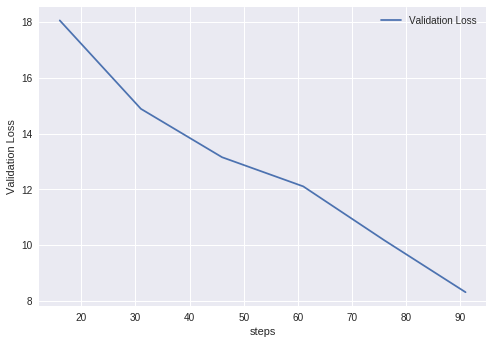

....INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-106
==== 106 ====
おはようございます。寒いですね。
    [0]おはようございます！ー。。。
    [1]おはようございます！ー。。[EOS]
さて帰ろう。明日は早い。
    [0]おつかれさまーー気気
    [1]おつかれさまーー。気
今回もよろしくです。
    [0]こちらこそよろしくお願いしし。。
    [1]こちらこそよろしくお願いしします。
validation loss 6.1730757
learning rate 0.05
32.03 msec/data
.......

In [0]:
import MeCab


def clean_model_path(model_path):
    shutil.rmtree(model_path)
    os.makedirs(model_path)


def print_header(text):
    print("============== {} ==============".format(text))


def test_tweets_small(hparams):
    print_header("train_loop_distributed_pattern")
    clean_model_path(hparams.model_path)

    source_path = "tweets_small.txt"
    download_file_if_necessary(source_path)
    generator = TrainDataGenerator(source_path=source_path, hparams=hparams)
    train_dataset, vocab, rev_vocab = generator.generate()

    tweets = ["おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。"]

    train_loop_distributed_pattern(train_dataset.repeat(100),
                                   train_dataset.repeat(100),
                                   vocab,
                                   rev_vocab,
                                   hparams, tweets, short_loop=False)


def test_tweets_small_swapped(hparams):
    print_header("train_loop_distributed_pattern swapped")

    clean_model_path(hparams.model_path)

    source_path = "tweets_small.txt"
    download_file_if_necessary(source_path)
    TrainDataGenerator.generate_source_target_swapped(p(source_path))

    swapped_path = "tweets_small_swapped.txt"

    generator = TrainDataGenerator(source_path=swapped_path, hparams=hparams)
    train_dataset, vocab, rev_vocab = generator.generate()

    replies = ["@higepon おはようございます！", "おつかれさまー。気をつけて。", "こちらこそよろしくお願いします。"]

    print_header("train_loop_distributed_pattern")
    train_loop_distributed_pattern(train_dataset.repeat(100),
                                   train_dataset.repeat(100),
                                   vocab,
                                   rev_vocab,
                                   hparams, replies, short_loop=False)

# vocab size 変えたら動かなくなった
tweet_small_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {
        'batch_size': 6,  # of tweets should be dividable by batch_size
        'encoder_length': 8,
        'decoder_length': 8,
        'num_units': 256,
        'num_layers': 2,
        'vocab_size': 34,
        'embedding_size': 40,
        'beam_width': 2,  # for faster iteration, this should be 10
        'num_train_steps': 200,
        'model_path': p(ModelDirectory.tweet_small.value),
        'learning_rate': 0.05,
        'use_attention': True,
    })

tweet_small_swapped_hparams = copy.deepcopy(
    tweet_small_hparams).override_from_dict(
    {'model_path': p(ModelDirectory.tweet_small_swapped.value)})

!rm tweets_small*
test_tweets_small(tweet_small_hparams)
test_tweets_small_swapped(tweet_small_swapped_hparams)


In [0]:
#!cat tweets_small_enc.txt

In [0]:
run_large = False
run_large_swapped = True


def test_tweets_large(hparams):
    print_header("train_loop_distributed_pattern")

    source_path = "tweets_large.txt"
    download_file_if_necessary(source_path)
    generator = TrainDataGenerator(source_path=source_path, hparams=hparams)
    train_dataset, vocab, rev_vocab = generator.generate()

    tweets = ["今日のドラマ面白そう！","お腹すいたー", "おやすみ～", "おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。", "ばいとおわ！"]

    train_loop_distributed_pattern(train_dataset.repeat().shuffle(1024),
                                   train_dataset.repeat().shuffle(1024, seed=1234),
                                   vocab,
                                   rev_vocab,
                                   hparams, tweets, short_loop=False,
                                   drive=drive)


def test_tweets_large_swapped(hparams):
    print_header("train_loop_distributed_pattern")

    source_path = "tweets_large.txt"
    download_file_if_necessary(source_path)
    swapped_source_path = TrainDataGenerator.generate_source_target_swapped(
        source_path)

    generator = TrainDataGenerator(source_path=swapped_source_path,
                                   hparams=hparams)
    train_dataset, vocab, rev_vocab = generator.generate()

    tweets = ["今日のドラマ面白そう！","お腹すいたー", "おやすみ～", "おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。", "ばいとおわ！"]


    train_loop_distributed_pattern(train_dataset.repeat().shuffle(1024),
                                   train_dataset.repeat().shuffle(1024, seed=1234),
                                   vocab,
                                   rev_vocab,
                                   hparams, tweets, short_loop=False,
                                   drive=drive)


tweet_large_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {
        # In typical seq2seq chatbot
        # num_layers=3, learning_rate=0.5, batch_size=64, vocab=20000-100000, learning_rate decay is 0.99, which is taken care as default parameter in AdamOptimizer.
        'batch_size': 64,  # of tweets should be dividable by batch_size
        'encoder_length': 30,
        'decoder_length': 30,
        'num_units': 1024,
        'num_layers': 3,
        'vocab_size': 50000,
        'embedding_size': 1024,
        'beam_width': 2,  # for faster iteration, this should be 10
        'num_train_steps': 1000000,
        'model_folder_in_drive': GoogleDriveFolder.seq2seq.value,
        'model_path': p(ModelDirectory.tweet_large.value),
        'learning_rate': 0.5, # For vocab_size 50000, num_layers 3, num_units 1024, tweet_large, starting learning_rate 0.05 works well, change it t0 0.01 at perplexity 800, changed it to 0.005 at 200.
        'learning_rate_decay': 0.99,
        'use_attention': True,
        # testing new restore learning rate and no USERNAME TOKEN
    })

tweet_large_swapped_hparams = copy.deepcopy(
    tweet_large_hparams).override_from_dict(
    {
        'model_folder_in_drive': GoogleDriveFolder.seq2seq_swapped.value,
        'model_path': p(ModelDirectory.tweet_large_swapped.value)
    })

if run_large:
    test_tweets_large(tweet_large_hparams)
if run_large_swapped:
    test_tweets_large_swapped(tweet_large_swapped_hparams)

In [0]:
##!rm tweets_large* 
#!rm -rf model/tweet_large
!ls
!grep  -in '^$' tweets_large_dec.txt

In [0]:
|def test_mutual_information(hparams, swapped_hparams):
    graph = tf.Graph()
    swapped_graph = tf.Graph()
    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True

    drive = make_drive()
    download_model_data_if_necessary(drive, hparams.model_folder_in_drive,
                                     p(ModelDirectory.tweet.value))
    download_model_data_if_necessary(drive,
                                     swapped_hparams.model_folder_in_drive,
                                     p(ModelDirectory.tweet_swapped.value))

    with graph.as_default():
        infer_sess = tf.Session(graph=graph, config=config)
        with tf.variable_scope('root'):
            model = ChatbotInferenceModel(infer_sess, hparams,
                                          model_path=p(ModelDirectory.tweet.value))
            model.restore()

    with swapped_graph.as_default():
        swap_sess = tf.Session(graph=swapped_graph, config=config)
        with tf.variable_scope('root'):
            smodel = ChatbotInferenceModel(swap_sess, swapped_hparams,
                                           model_path=p(
                                               ModelDirectory.tweet_swapped.value))
            smodel.restore()
            helper = InferenceHelper(model, vocab, rev_vocab)
            helper.print_inferences("疲れた")

            shelper = InferenceHelper(smodel, vocab, rev_vocab)
            shelper.print_inferences("お疲れ様")


#large_beam_hparams = copy.deepcopy(large_hparams)
#large_beam_hparams.beam_width = 20
#test_mutual_information(large_beam_hparams, large_swapped_hparams)


In [0]:
ｑ